In [23]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import numpy as np

In [24]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train[:5000]
y_train = y_train[:5000]
x_test = x_test[:1000]
y_test = y_test[:1000]
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (5000, 32, 32, 3) - y_train shape: (5000, 1)
x_test shape: (1000, 32, 32, 3) - y_test shape: (1000, 1)


In [25]:
#Creation of the patches
P = 2 #Size of the patches
W = x_train[0].shape[0]
H = x_train[0].shape[1]
N = int(H*W/(P*P))
C = 3
def patchData(data):
  data_patched = []
  for i in range(len(data)):
    data_patched.append(np.reshape(data[i],(N,int(P*P*C))))
  data_patched = np.array(data_patched)
  return data_patched

In [26]:
def getEmbeddingInput(x_train_patched,D):
  projection = tf.keras.layers.Dense(units=D)(x_train_patched)
  #Position embedding
  input_tensor = tf.keras.Input(shape=x_train_patched.shape)
  # Build the positions.
  positions = tf.range(start=0, limit=N, delta=1,dtype='float32')
  # Encode the positions with an Embedding layer.
  encoded_positions = layers.Embedding(input_dim=N, output_dim=D)(positions)
  transformer_input = projection + encoded_positions
  transformer_input = tf.keras.layers.Dropout(0.1)(transformer_input)
  return transformer_input

In [27]:
def createModel(L,D):
  #Get the inputs
  inputs = tf.keras.layers.Input(shape=(N,P*P*C))
  input = getEmbeddingInput(inputs,D)
  #Stack of L encoder
  for i in range (L):
    norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)(input)
    msa = MultiHeadAttention(num_heads=4, key_dim=D)(norm,norm)
    output= tf.keras.layers.Add()([input,msa])
    norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(output)
    #MLP
    mlp = layers.Dense(D*2, activation=tf.nn.gelu)(norm2)
    mlp = layers.Dropout(0.1)(mlp)
    mlp = layers.Dense(D, activation=tf.nn.gelu)(mlp)
    mlp = layers.Dropout(0.1)(mlp)
    input = tf.keras.layers.Add()([mlp,output])

  representation = LayerNormalization(epsilon=1e-6)(input)
  representation = Flatten()(representation)
  representation = Dropout(0.5)(representation)
  # Add MLP.
  mlp = layers.Dense(2048, activation=tf.nn.gelu)(representation)
  mlp = layers.Dropout(0.5)(mlp)
  mlp = layers.Dense(1024, activation=tf.nn.gelu)(mlp)
  mlp = layers.Dropout(0.5)(mlp)
  # Classify outputs.
  final_output = Dense(10,activation="softmax")(mlp)
  model = keras.Model(inputs=inputs, outputs=final_output)
  return model


In [28]:
def trainModel(model):
  optimizer = tf.optimizers.Adam(learning_rate=0.0002, decay=0.1)
  model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

  history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=512,
        epochs=20,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  return history,accuracy

Training for different values of L and D

In [ ]:
x_train = patchData(x_train)
x_test = patchData(x_test)
print(x_train.shape)
result=[]

L = [2,4,8]
D = [10,50,90,128]
for l in L:
  for d in D:
    model = createModel(l,d)
    model.summary()
    history,accuracy = trainModel(model)
    result.append([D,L,accuracy])

Results



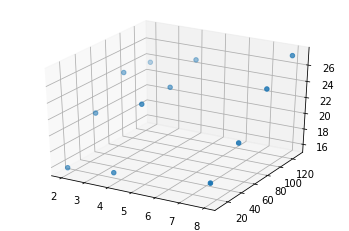

In [21]:
L=[2,2,2,2,4,4,4,4,8,8,8,8]
D = [10,50,90,128,10,50,90,128,10,50,90,128]
Accuracy = [15.8,20.7,23.9,23.5,16.4,22.9,23.1,24.8,17.6,20.4,25.0,27.3]
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.scatter3D(L,D,Accuracy)

The best result is obtained for L=8 and D=128 with an accuracy of 27.3 %